# **GCN + LSTM гибридная модель для анализа поведения пользователей**

In [73]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Загрузка данных:
* Загружаются данные из CSV-файлов, включая информацию об узлах, рёбрах и ресурсах.
* Для узлов (пользователей) извлекаются такие признаки, как роль пользователя, количество логинов, уровень доступа и время с последнего входа.
* Для ресурсов вычисляются дополнительные признаки, такие как тип ресурса и уровень доступа.

In [74]:
edges_df = pd.read_csv("data/edges4.csv", parse_dates=["timestamp"])
nodes_df = pd.read_csv("data/nodes4.csv")
resources_df = pd.read_csv("data/resources4.csv")
edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'], errors='coerce')
edges_df = edges_df.dropna(subset=['timestamp'])

### Исследование данных

In [75]:
merged_data = pd.merge(edges_df, nodes_df, left_on='source_user', right_on='user_id', how='left')
merged_data = pd.merge(merged_data, resources_df, left_on='target_resource', right_on='resource_id', how='left')

In [76]:
# Преобразование столбца timestamp в формат datetime
edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'], errors='coerce')

# Фильтрация записей с выходными днями: суббота (5) и воскресенье (6)
edges_weekend = edges_df[edges_df['timestamp'].dt.weekday >= 5]

edges_weekend

,event_id,source_user,target_resource,event_type,timestamp,weight
6,6,6,1,modification,2025-03-02 15:30:26.762,0.251472
14,14,8,10,modification,2024-07-07 15:30:26.762,0.218190
18,18,18,4,modification,2024-08-31 15:30:26.762,0.320103
56,56,18,4,deletion,2024-12-22 15:30:26.762,0.278458
59,59,10,10,modification,2024-09-29 15:30:26.762,0.457324
67,67,18,4,modification,2024-11-24 02:29:26.763,0.992502
75,75,18,3,deletion,2024-08-24 02:29:26.763,0.543522
96,96,18,4,deletion,2024-08-03 02:29:26.763,0.479871
99,99,18,3,access,2024-12-15 02:29:26.763,0.691558


In [77]:
# Рабочее время и праздники
start_hour = 9
end_hour = 18
holidays = pd.to_datetime([
    "2025-01-01", "2025-01-07", "2025-02-23", "2025-03-08",
    "2025-05-01", "2025-05-09", "2025-06-12", "2025-11-04"
])

# Дополнительные признаки
edges_df['date'] = pd.to_datetime(edges_df['timestamp'].dt.date)
edges_df['hour'] = edges_df['timestamp'].dt.hour
edges_df['weekday'] = edges_df['timestamp'].dt.weekday

# Фильтрация: будни, рабочие часы, не праздники
edges_working_time = edges_df[
    (edges_df['weekday'] < 5) &
    (edges_df['hour'] >= start_hour) &
    (edges_df['hour'] < end_hour) &
    (~edges_df['date'].isin(holidays))
]
# Вывод результата
edges_working_time
#print(edges_working_time)


,event_id,source_user,target_resource,event_type,timestamp,weight,date,hour,weekday
0,0,16,0,access,2024-11-13 15:30:26.762,0.878412,2024-11-13,15,2
1,1,3,3,access,2024-12-26 17:30:26.762,0.554266,2024-12-26,17,3
2,2,17,5,modification,2024-12-11 15:30:26.762,0.326337,2024-12-11,15,2
3,3,10,10,deletion,2024-12-09 12:30:26.762,0.927744,2024-12-09,12,0
4,4,19,2,access,2024-05-23 15:30:26.762,0.971606,2024-05-23,15,3
...,...,...,...,...,...,...,...,...,...
91,91,17,1,deletion,2024-07-08 13:29:26.763,0.611183,2024-07-08,13,0
92,92,6,5,deletion,2024-12-30 12:29:26.763,0.894500,2024-12-30,12,0
93,93,0,10,modification,2025-05-06 12:29:26.763,0.949740,2025-05-06,12,1
97,97,4,11,modification,2024-08-08 17:49:26.763,0.664381,2024-08-08,17,3


In [78]:
edges_non_working_days = edges_df[
    (edges_df['weekday'] >= 5) |  # Суббота, воскресенье
    (edges_df['date'].isin(holidays))  # Праздники
]

edges_non_working_hours = edges_df[
    (edges_df['weekday'] < 5) &  # Будни
    (
        (edges_df['hour'] < start_hour) |
        (edges_df['hour'] >= end_hour)
    ) &
    (~edges_df['date'].isin(holidays))  # Не праздники
]

# Объединение всех нерабочих периодов
edges_non_working_combined = pd.concat([edges_non_working_days, edges_non_working_hours]).drop_duplicates()

user_id = 7  # Замените на нужный ID
user_edges = edges_non_working_combined[edges_non_working_combined['source_user'] == user_id]

edges_non_working_combined

,event_id,source_user,target_resource,event_type,timestamp,weight,date,hour,weekday
6,6,6,1,modification,2025-03-02 15:30:26.762,0.251472,2025-03-02,15,6
14,14,8,10,modification,2024-07-07 15:30:26.762,0.218190,2024-07-07,15,6
18,18,18,4,modification,2024-08-31 15:30:26.762,0.320103,2024-08-31,15,5
56,56,18,4,deletion,2024-12-22 15:30:26.762,0.278458,2024-12-22,15,6
59,59,10,10,modification,2024-09-29 15:30:26.762,0.457324,2024-09-29,15,6
67,67,18,4,modification,2024-11-24 02:29:26.763,0.992502,2024-11-24,2,6
75,75,18,3,deletion,2024-08-24 02:29:26.763,0.543522,2024-08-24,2,5
95,95,14,4,modification,2025-01-07 20:29:26.763,0.224453,2025-01-07,20,1
96,96,18,4,deletion,2024-08-03 02:29:26.763,0.479871,2024-08-03,2,5
99,99,18,3,access,2024-12-15 02:29:26.763,0.691558,2024-12-15,2,6


Создадим индикатор подозрительности, основанный на нескольких факторах:

* Частота событий: пользователи, проявляющие повышенную активность.
* Типы событий: определение необычных событий (редких, несвойственных типу пользователя).
* Время обращения: обращает внимание на работу в ночное время или праздники.


In [79]:
suspiciousness_score = merged_data.groupby('source_user').agg({
    'event_id': 'count',  # число событий
    'timestamp': lambda x: (pd.Series(x).diff()).mean(),  # среднее время между событиями
    'event_type': lambda x: x.nunique()  # разнообразие событий
}).reset_index()

suspiciousness_score.rename(columns={
    'event_id': 'total_events',
    'timestamp': 'avg_event_interval',
    'event_type': 'event_types'
}, inplace=True)

Нормализуем данные и применим метод изолирующих лесов (Isolation Forest) для определения аномалий:

In [80]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Преобразуем TimeDelta в секунды
suspiciousness_score['avg_event_interval_seconds'] = suspiciousness_score['avg_event_interval'].apply(
    lambda x: x.total_seconds() if pd.notnull(x) else np.nan
)

# Выбираем только числовые признаки
columns_to_scale = ['total_events', 'avg_event_interval_seconds', 'event_types']
# Проверим наличие NaN в целевых колонках
print("NaN values before imputation:")
print(suspiciousness_score[columns_to_scale].isnull().sum())

# Импутация NaN значений средним
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(suspiciousness_score[columns_to_scale])

# Масштабирование признаков
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Обнаружение аномалий
iso_forest = IsolationForest(contamination=0.05, random_state=42)
suspicious_scores = iso_forest.fit_predict(scaled_data)

# Добавим результат обратно в DataFrame
suspiciousness_score['is_suspicious'] = suspicious_scores

# Проверим количество аномалий
print("Количество аномалий (label = -1):", (suspicious_scores == -1).sum())


suspiciousness_score_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale)
suspiciousness_score_scaled['source_user'] = suspiciousness_score['source_user']
suspiciousness_score_scaled['is_suspicious'] = suspicious_scores


NaN values before imputation:
total_events                  0
avg_event_interval_seconds    1
event_types                   0
dtype: int64
Количество аномалий (label = -1): 1


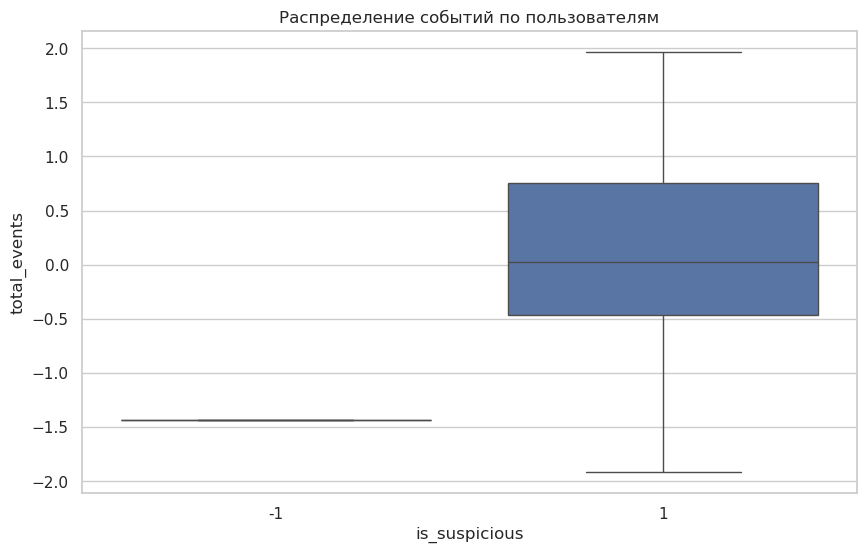

   total_events  avg_event_interval_seconds  event_types  source_user  \
8     -1.431381                    3.288008    -1.801972            8   

   is_suspicious  
8             -1  


In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Построим график подозрительных пользователей
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x="is_suspicious", y="total_events", data=suspiciousness_score_scaled)
plt.title("Распределение событий по пользователям")
plt.show()

# Выведем топ подозреваемых пользователей
top_suspects = suspiciousness_score_scaled[suspiciousness_score_scaled['is_suspicious'] == -1].head()
print(top_suspects)

In [82]:
top_suspects

,total_events,avg_event_interval_seconds,event_types,source_user,is_suspicious
8,-1.431381,3.288008,-1.801972,8,-1


In [83]:
# Просмотр первых строк каждого датасета
nodes_preview = nodes_df.head()
edges_preview = edges_df.head()
resources_preview = resources_df.head()

nodes_df.info(), edges_df.info(), resources_df.info(), nodes_preview, edges_preview, resources_preview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          20 non-null     int64  
 1   name             20 non-null     object 
 2   role             20 non-null     object 
 3   login_count      20 non-null     int64  
 4   access_level     20 non-null     int64  
 5   session_time     20 non-null     float64
 6   var_activity     20 non-null     float64
 7   last_login_time  20 non-null     object 
dtypes: float64(2), int64(3), object(3)
memory usage: 1.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 99
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_id         99 non-null     int64         
 1   source_user      99 non-null     int64         
 2   target_resource  99 non-null     int64         
 3   event_typ

(None,
 None,
 None,
    user_id    name       role  login_count  access_level  session_time  \
 0        0  User_0    manager          845             2       2208.41   
 1        1  User_1  accounter          647             3       1271.21   
 2        2  User_2  accounter          717             2       2587.04   
 3        3  User_3  developer          600             4       1489.21   
 4        4  User_4    manager          846             3       2884.10   
 
    var_activity      last_login_time  
 0          2.65  2025-05-02 02:29:26  
 1          6.56  2025-04-26 02:29:26  
 2          5.80  2025-04-20 02:29:26  
 3          8.60  2025-04-26 02:29:26  
 4          8.51  2025-04-16 02:29:26  ,
    event_id  source_user  target_resource    event_type  \
 0         0           16                0        access   
 1         1            3                3        access   
 2         2           17                5  modification   
 3         3           10               10    

In [84]:
# Преобразуем last_login_time в datetime
nodes_df["last_login_time"] = pd.to_datetime(nodes_df["last_login_time"])

# Объединим события с информацией о пользователях и ресурсах
events_merged = edges_df.merge(nodes_df, left_on="source_user", right_on="user_id")
events_merged = events_merged.merge(resources_df, left_on="target_resource", right_on="resource_id", suffixes=("_user", "_resource"))

# 1. Несоответствие уровня доступа
suspicious_access_level = events_merged[events_merged["access_level_user"] < events_merged["access_level_resource"]]

# 2. Доступ к важным ресурсам с модификацией или удалением
high_importance_actions = events_merged[
    (events_merged["importance"] >= 3) &
    (events_merged["event_type"].isin(["modification", "deletion"]))
]

# 3. Пользователи с высокой дисперсией активности и временем сессии
activity_threshold = nodes_df["var_activity"].quantile(0.9)
session_threshold = nodes_df["session_time"].quantile(0.9)
high_activity_users = nodes_df[
    (nodes_df["var_activity"] > activity_threshold) |
    (nodes_df["session_time"] > session_threshold)
]

# 4. Пользователи с необычно частыми входами
login_threshold = nodes_df["login_count"].quantile(0.9)
frequent_logins = nodes_df[nodes_df["login_count"] > login_threshold]

# Объединим всех подозрительных пользователей
suspicious_users = pd.concat([
    suspicious_access_level[["user_id", "name", "event_type", "resource_type", "importance"]],
    high_importance_actions[["user_id", "name", "event_type", "resource_type", "importance"]],
    high_activity_users[["user_id", "name", "role", "var_activity", "session_time"]],
    frequent_logins[["user_id", "name", "role", "login_count"]]
]).drop_duplicates(subset=["user_id"])

#import ace_tools as tools
#tools.display_dataframe_to_user(name="Подозрительные пользователи", dataframe=suspicious_users)


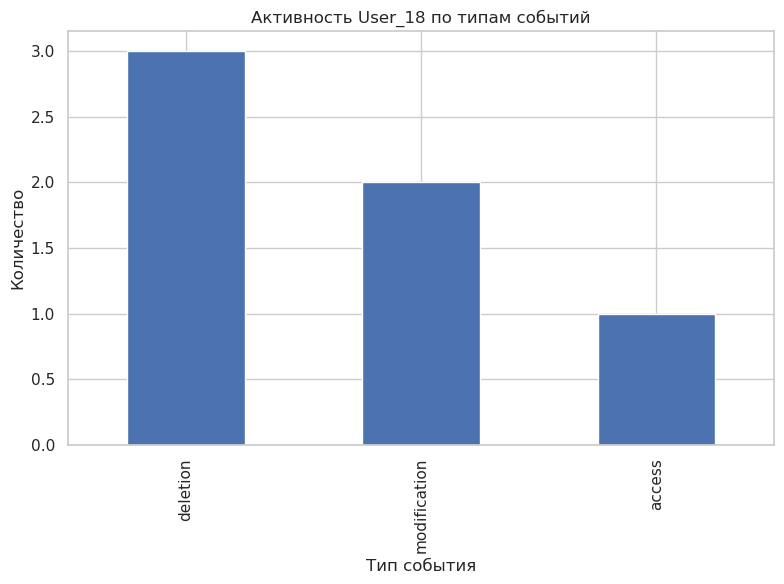

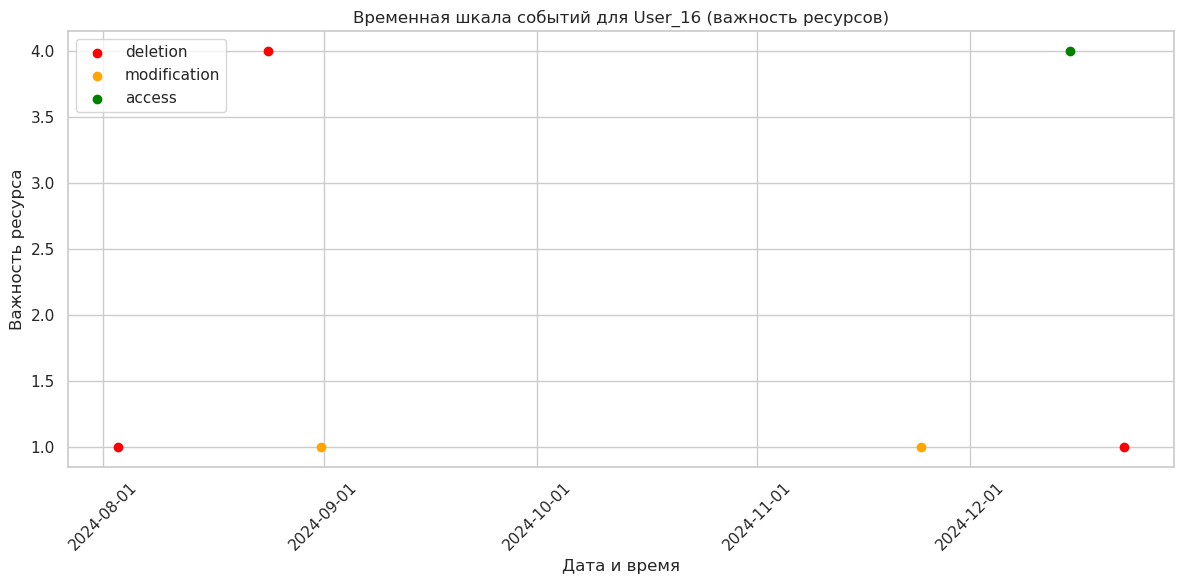

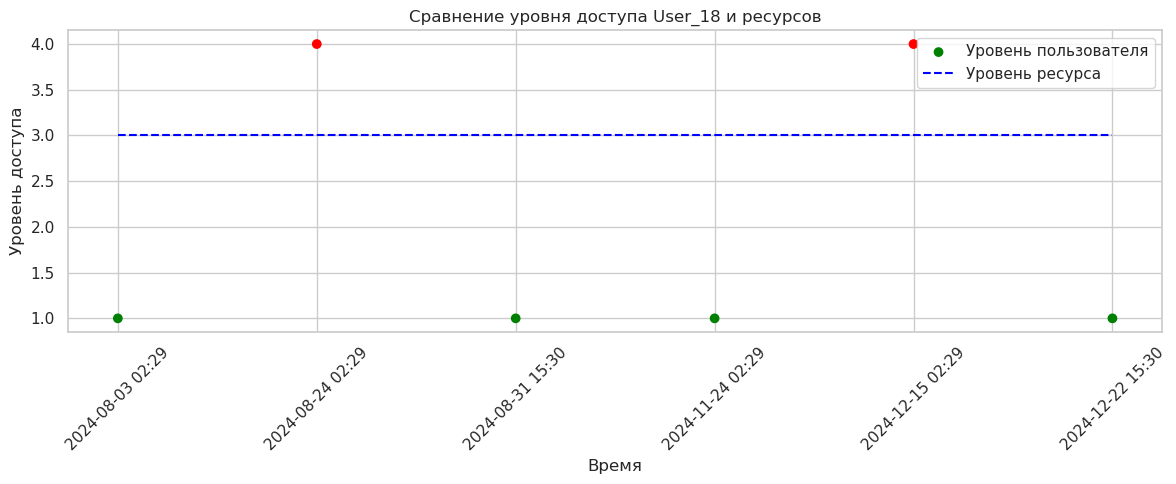

In [85]:
import matplotlib.pyplot as plt

# Фильтрация событий для User_16
user_id_16 = nodes_df[nodes_df["name"] == "User_18"]["user_id"].iloc[0]
user16_events = events_merged[events_merged["user_id"] == user_id_16].sort_values("timestamp")

# Подготовка данных для визуализации
event_counts = user16_events["event_type"].value_counts()
timeline = user16_events[["timestamp", "event_type", "resource_type", "importance", "access_level_resource"]]

# Построение графика активности по типам событий
plt.figure(figsize=(8, 6))
event_counts.plot(kind="bar")
plt.title("Активность User_18 по типам событий")
plt.xlabel("Тип события")
plt.ylabel("Количество")
plt.grid(True)
plt.tight_layout()
plt.show()

# Отобразим временную шкалу событий пользователя User_16
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
colors = {'access': 'green', 'modification': 'orange', 'deletion': 'red'}

# Отображение точек на временной шкале
for idx, row in user16_events.iterrows():
    plt.scatter(row["timestamp"], row["importance"],
                color=colors.get(row["event_type"], 'gray'),
                label=row["event_type"] if row["event_type"] not in plt.gca().get_legend_handles_labels()[1] else "")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title("Временная шкала событий для User_16 (важность ресурсов)")
plt.xlabel("Дата и время")
plt.ylabel("Важность ресурса")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Сопоставим уровень доступа пользователя с уровнем доступа ресурсов
access_comparison = user16_events[["timestamp", "resource_type", "access_level_user", "access_level_resource"]].copy()
access_comparison["access_mismatch"] = access_comparison["access_level_user"] < access_comparison["access_level_resource"]

# Построим визуализацию
plt.figure(figsize=(12, 5))
mismatch_colors = access_comparison["access_mismatch"].map({True: "red", False: "green"})
formatted_timestamps = access_comparison["timestamp"].dt.strftime('%Y-%m-%d %H:%M')

plt.scatter(formatted_timestamps, access_comparison["access_level_resource"],
            c=mismatch_colors)
plt.plot(formatted_timestamps, access_comparison["access_level_user"], label="Уровень доступа пользователя", color='blue', linestyle='--')

plt.xticks(rotation=45)
plt.title("Сравнение уровня доступа User_18 и ресурсов")
plt.xlabel("Время")
plt.ylabel("Уровень доступа")
plt.legend(["Уровень пользователя", "Уровень ресурса"])
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_79522/622559607.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  event_counts_full = pd.DataFrame(index=nodes_df["name"], columns=['access', 'modification', 'deletion']).fillna(0)


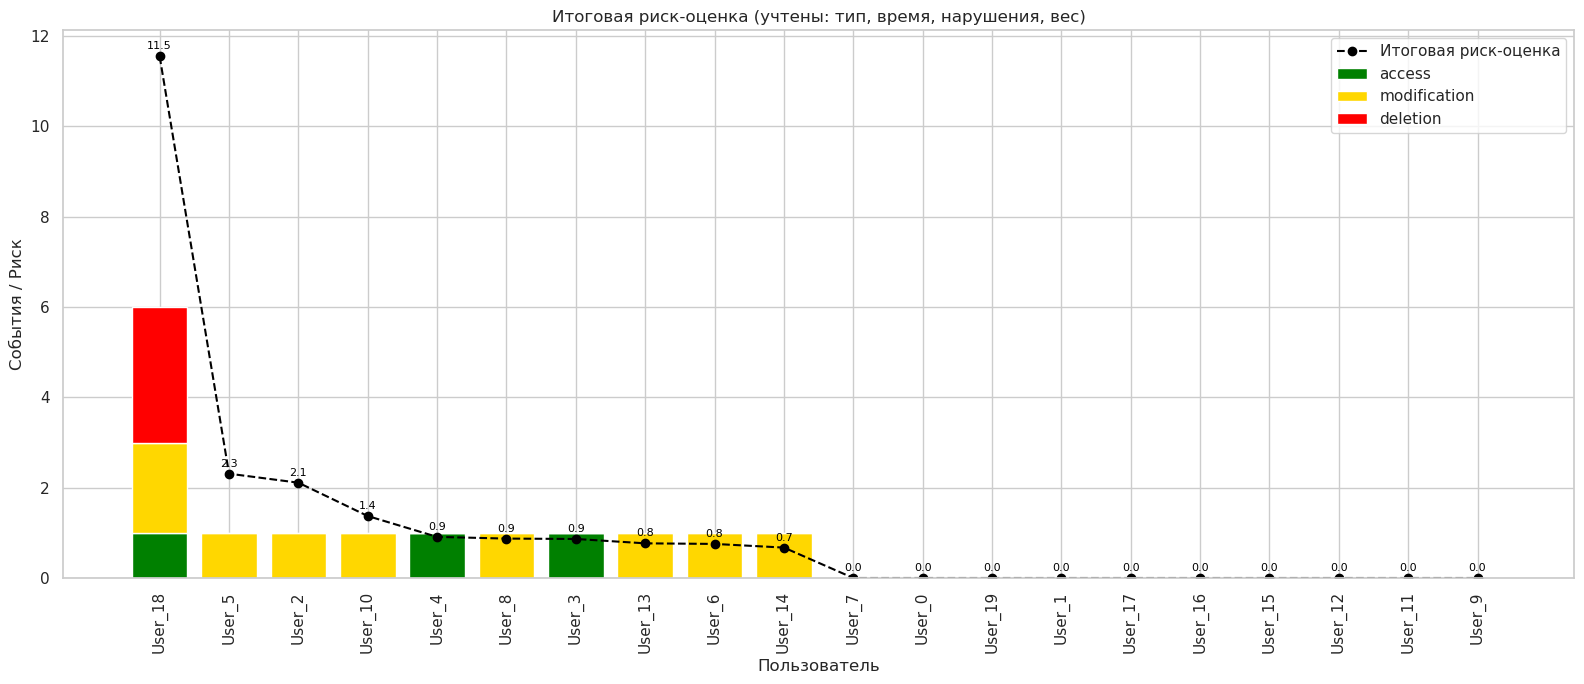

In [86]:
# === Очистка некорректных дат ===
edges_df["timestamp"] = pd.to_datetime(edges_df["timestamp"])

# === Выделим события в нерабочее время ===
edges_df["hour"] = edges_df["timestamp"].dt.hour
edges_df["dayofweek"] = edges_df["timestamp"].dt.dayofweek
edges_df["is_after_hours"] = (edges_df["hour"] < 9) | (edges_df["hour"] > 18) | (edges_df["dayofweek"] >= 5)

# === Расчёт итоговой риск-оценки ===
all_events_df = edges_df[edges_df["is_after_hours"]].copy()
all_events_df = all_events_df.merge(nodes_df[["user_id", "access_level"]], left_on="source_user", right_on="user_id", how="left")
all_events_df = all_events_df.merge(resources_df[["resource_id", "access_level"]],
                                    left_on="target_resource", right_on="resource_id", how="left",
                                    suffixes=("_user", "_resource"))
all_events_df["access_violation"] = (all_events_df["access_level_user"] < all_events_df["access_level_resource"]).astype(int)

# Коэффициенты по типам событий
event_weights = {"access": 0.5, "modification": 1.0, "deletion": 1.0}
all_events_df["event_type_weight"] = all_events_df["event_type"].map(event_weights)

# Формула итоговой риск-оценки
all_events_df["event_risk"] = (
    all_events_df["event_type_weight"] *
    all_events_df["weight"] *
    all_events_df["access_level_user"] *
    (1 + all_events_df["access_violation"])
)

# Группировка по пользователям
final_risk_scores = all_events_df.groupby("source_user")["event_risk"].sum().reset_index(name="final_risk_score")
user_risk_df = nodes_df.merge(final_risk_scores, left_on="user_id", right_on="source_user", how="left").fillna(0)
user_risk_df["final_risk_score"] = user_risk_df["final_risk_score"]

# === Подсчёт событий по типам для всех пользователей ===
after_hours_df = edges_df[edges_df["is_after_hours"]].merge(nodes_df[["user_id", "name"]],
                                                             left_on="source_user", right_on="user_id", how="left")
event_counts = after_hours_df.groupby(['name', 'event_type']).size().unstack(fill_value=0)
for col in ['access', 'modification', 'deletion']:
    if col not in event_counts.columns:
        event_counts[col] = 0

event_counts_full = pd.DataFrame(index=nodes_df["name"], columns=['access', 'modification', 'deletion']).fillna(0)
event_counts_merged = event_counts_full.add(event_counts, fill_value=0)

# Добавим итоговую риск-оценку
event_counts_merged["risk_score"] = user_risk_df.set_index("name")["final_risk_score"]
event_counts_sorted = event_counts_merged.sort_values(by="risk_score", ascending=False)

# === Визуализация ===
plt.figure(figsize=(16, 7))

plt.bar(event_counts_sorted.index, event_counts_sorted['access'], color='green', label='access')
plt.bar(event_counts_sorted.index, event_counts_sorted['modification'],
        bottom=event_counts_sorted['access'], color='gold', label='modification')
plt.bar(event_counts_sorted.index, event_counts_sorted['deletion'],
        bottom=event_counts_sorted['access'] + event_counts_sorted['modification'],
        color='red', label='deletion')

plt.plot(event_counts_sorted.index, event_counts_sorted["risk_score"],
         color='black', marker='o', linestyle='--', label='Итоговая риск-оценка')

# Подписи к точкам риска
for i, value in enumerate(event_counts_sorted["risk_score"]):
    plt.annotate(f'{value:.1f}', xy=(i, value), xytext=(0, 5),
                 textcoords="offset points", ha='center', fontsize=8, color='black')

plt.xticks(rotation=90)
plt.xlabel("Пользователь")
plt.ylabel("События / Риск")
plt.title("Итоговая риск-оценка (учтены: тип, время, нарушения, вес)")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_79522/2629823374.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


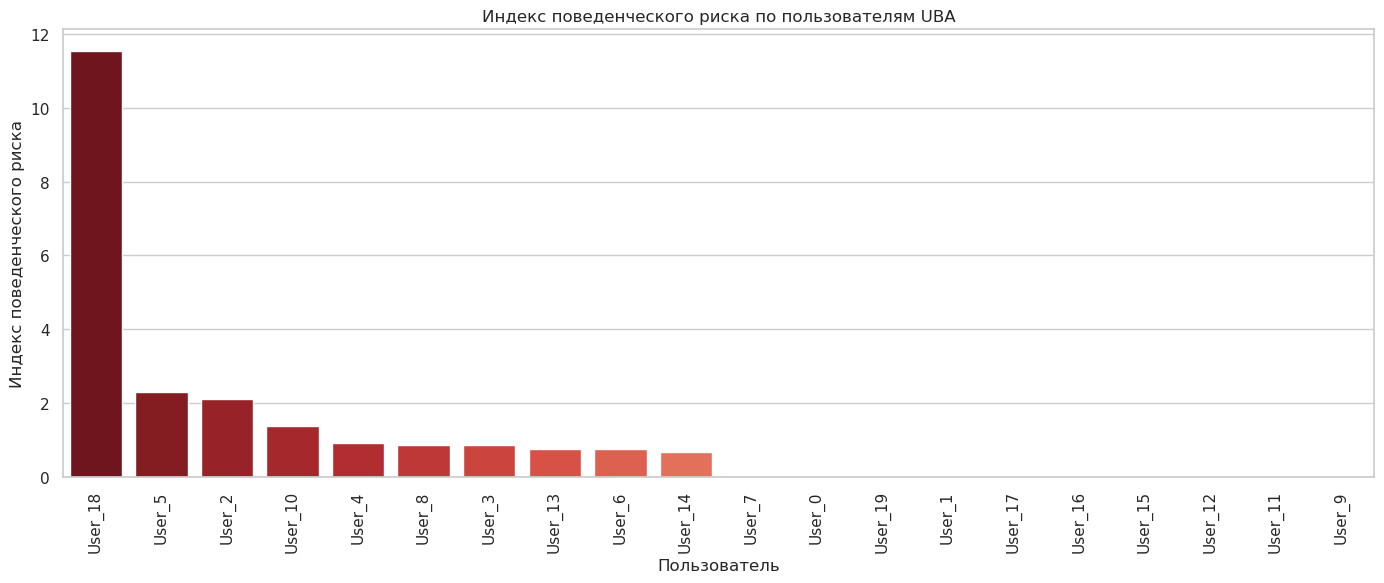

In [87]:
import seaborn as sns

# Построим диаграмму риск-оценки: поведенческий риск — пользователь
plt.figure(figsize=(14, 6))
sns.barplot(
    x=event_counts_sorted.index,
    y=event_counts_sorted["risk_score"],
    palette="Reds_r"
)

plt.xticks(rotation=90)
plt.xlabel("Пользователь")
plt.ylabel("Индекс поведенческого риска")
plt.title("Индекс поведенческого риска по пользователям UBA")
plt.tight_layout()
plt.show()

/tmp/ipykernel_79522/801359354.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


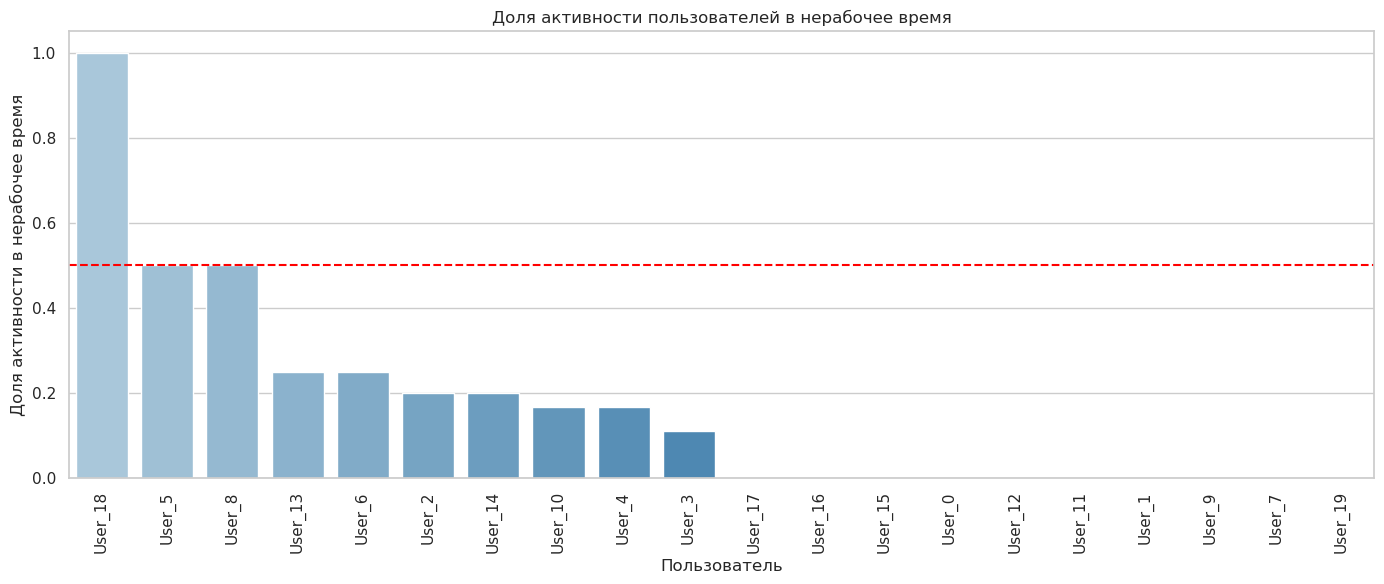

In [88]:
# Подсчёт общего количества событий и количества в нерабочее время
total_events = edges_df.groupby("source_user").size().reset_index(name="total_events")
after_hours_events = edges_df[edges_df["is_after_hours"]].groupby("source_user").size().reset_index(name="after_hours_events")

# Объединение
activity_ratio_df = pd.merge(total_events, after_hours_events, on="source_user", how="left").fillna(0)
activity_ratio_df["after_hours_ratio"] = activity_ratio_df["after_hours_events"] / activity_ratio_df["total_events"]

# Добавим имена пользователей
activity_ratio_df = activity_ratio_df.merge(nodes_df[["user_id", "name"]], left_on="source_user", right_on="user_id", how="left")

# Сортировка по доле
activity_ratio_df = activity_ratio_df.sort_values(by="after_hours_ratio", ascending=False)

# Построение графика
plt.figure(figsize=(14, 6))
sns.barplot(
    x=activity_ratio_df["name"],
    y=activity_ratio_df["after_hours_ratio"],
    palette="Blues_d"
)
# Горизонтальная линия на уровне 0.5
plt.axhline(0.5, color='red', linestyle='--', linewidth=1.5, label="Порог 50%")

plt.xticks(rotation=90)
plt.xlabel("Пользователь")
plt.ylabel("Доля активности в нерабочее время")
plt.title("Доля активности пользователей в нерабочее время")
plt.tight_layout()
plt.show()

### Предобработка данных:
* Для категориальных признаков используется LabelEncoder для преобразования строковых значений в числовые.
* Создаётся матрица признаков для пользователей и ресурсов, которая объединяется в одну матрицу x.
* Формируется индекс рёбер edge_index, который указывает на связи между пользователями и ресурсами.

### GCN (Graph Convolutional Network):
* Используется слой GCN из библиотеки torch_geometric. Это сверточный слой, который работает с графами и учитывает связи между узлами.
* Применяется активация ReLU для улучшения нелинейности модели.

In [89]:
# === GCN часть: признаки узлов и edge_index ===
le_role = LabelEncoder()
nodes_df['role_encoded'] = le_role.fit_transform(nodes_df['role'])
nodes_df['last_login_time'] = pd.to_datetime(nodes_df['last_login_time'])
ref_date = pd.Timestamp("2025-05-07")
nodes_df['days_since_login'] = (ref_date - nodes_df['last_login_time']).dt.days
user_features = nodes_df[['role_encoded', 'login_count', 'access_level', 'session_time', 'var_activity', 'days_since_login']].values
resources_df['resource_type_encoded'] = LabelEncoder().fit_transform(resources_df['resource_type'])
res_base_features = resources_df[['resource_type_encoded', 'access_count_last_month', 'importance', 'access_level']].values
res_padded = np.hstack([res_base_features, np.zeros((res_base_features.shape[0], 2))])
# Входные данные, которые одержит собъединенные признаки узлов графа (пользователей и ресурсов).
x_combined = np.vstack([user_features, res_padded])
# Cоздается тензор (многомерный массив) из данных x_combined с использованием библиотеки PyTorch, преобразуя их в тип данных float
# Этот тензор x будет использоваться как входные данные для GCN (Graph Convolutional Network) части модели
x = torch.tensor(x_combined, dtype=torch.float)
# Количество строк в DataFrame nodes_df, то есть количество узлов-пользователей.
# Переменная offset будет использоваться для корректной индексации узлов-ресурсов
offset = nodes_df.shape[0]
# Извлекаем столбец source_user из DataFrame edges_df (источники рёбер - пользователи), преобразуем значения в целые числа и получает NumPy массив
sources = edges_df['source_user'].astype(int).values
# Извлекаем столбец target_resource (цели рёбер - ресурсы), преобразуем в целые числа и получает NumPy массив
# Добавляя offset, мы гарантируем, что:
# Все пользователи имеют уникальные индексы
# Все ресурсы имеют уникальные индексы
# Никакой ресурс не получит тот же индекс, что и пользователь
# Преобразует индексы ресурсов из их локальной нумерации (0,1,2...) в глобальную систему индексов графа.
targets = edges_df['target_resource'].astype(int).values + offset
# объединяем массивы источников и целей в одну матрицу размером 2×N (где N - количество рёбер).
# Первая строка - индексы источников.
# Вторая строка - индексы целей
matrix_2_idext = np.vstack([sources, targets])

Строка ниже преобразует эту матрицу в тензор PyTorch с типом long (целые числа).

edge_index - это тензор формы [2, num_edges], который представляет все связи в графе в формате, ожидаемом PyTorch Geometric.

Например:

 [[0, 1, 2],  - Источники (пользователи)

 [3, 4, 5]]   - Цели (ресурсы со смещением)
 означает, что:
 * пользователь 0 связан с ресурсом 3
 * пользователь 1 связан с ресурсом 4
 * пользователь 2 связан с ресурсом 5


In [90]:
edge_index = torch.tensor(matrix_2_idext, dtype=torch.long)

Строка ниже создаёт тензор PyTorch с метками (целевыми значениями) для узлов графа, которые будут использоваться для обучения модели.

Детализация:
1. nodes_df['role_encoded']:
* Обращается к столбцу role_encoded в DataFrame nodes_df
* Этот столбец содержит закодированные числовые значения ролей пользователей (например, администратор=0, модератор=1, пользователь=2 и т.д.)
* Кодирование было выполнено ранее с помощью LabelEncoder()

2. .values:
* Преобразует столбец Pandas в массив NumPy
* Например, может получиться массив вида: array([0, 1, 2, 0, 1, ...])

3. dtype=torch.long:
* Указывает, что тензор должен содержать целочисленные значения (64-битные целые числа)
* Тип long обычно используется для меток классов в PyTorch

4. torch.tensor():
* Создаёт тензор PyTorch из массива NumPy
* Результат будет выглядеть примерно так: tensor([0, 1, 2, 0, 1, ...])

Контекст использования:
* В графовых нейронных сетях y представляет собой целевые метки для узлов
* В данном случае это закодированные роли пользователей, которые модель будет пытаться предсказывать
* Форма тензора y будет [num_nodes,], где num_nodes - количество узлов-пользователей

Пример:
Если в nodes_df 5 пользователей с ролями:

   role_encoded
0            0
1            1
2            2
3            0
4            1
Тогда y будет:

python
tensor([0, 1, 2, 0, 1])
Этот тензор будет использоваться как целевые значения при обучении модели классификации ролей пользователей на основе их поведения и взаимодействий с ресурсами.

In [91]:
y = torch.tensor(nodes_df['role_encoded'].values, dtype=torch.long)

data = Data(x=x, edge_index=edge_index)

Количество пользователей (offset): 20


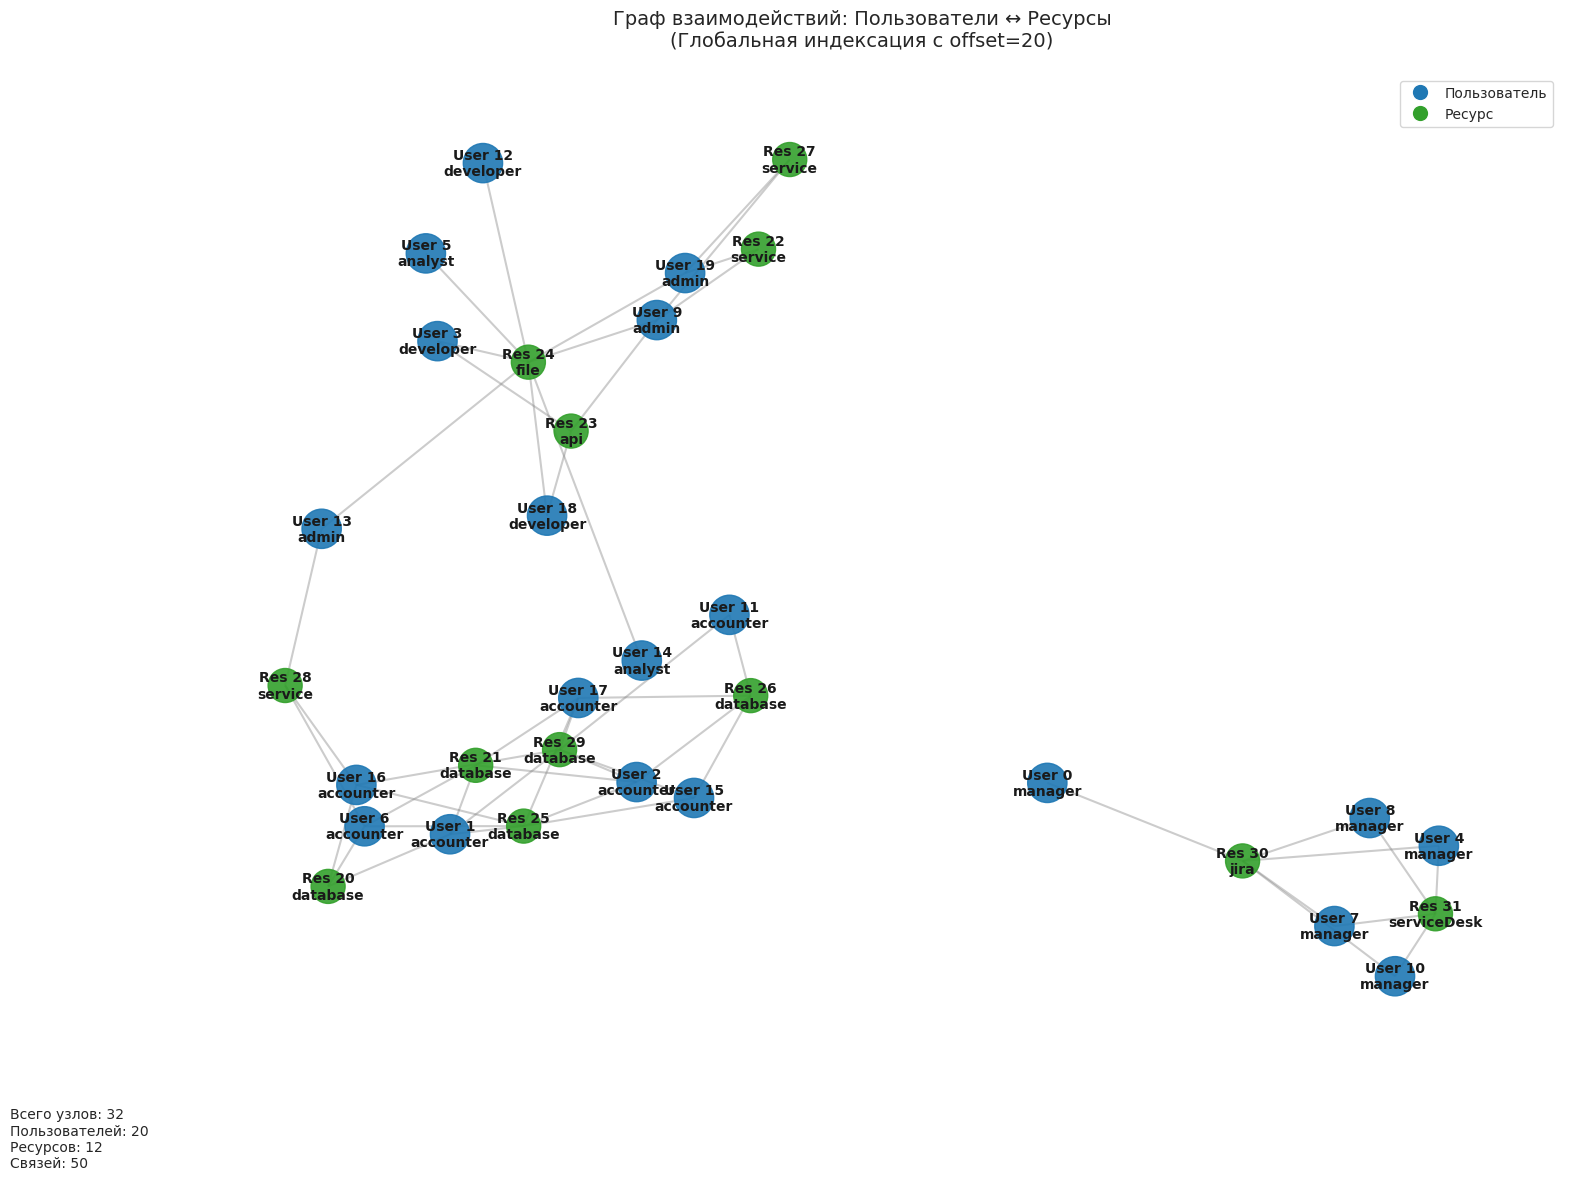

In [92]:
import networkx as nx

def visualize_interaction_graph(nodes_df, resources_df, edges_df):
    """Визуализирует граф взаимодействий с правильной индексацией через offset."""

    # Проверка данных
    required_node_cols = ['role']
    required_resource_cols = ['resource_type']
    required_edge_cols = ['source_user', 'target_resource', 'weight']

    if not all(col in nodes_df.columns for col in required_node_cols):
        raise ValueError(f"nodes_df должен содержать столбцы: {required_node_cols}")
    if not all(col in resources_df.columns for col in required_resource_cols):
        raise ValueError(f"resources_df должен содержать столбцы: {required_resource_cols}")
    if not all(col in edges_df.columns for col in required_edge_cols):
        raise ValueError(f"edges_df должен содержать столбцы: {required_edge_cols}")

    # 1. Создаем граф
    G = nx.Graph()

    # 2. Вычисляем offset - количество пользователей
    offset = len(nodes_df)
    print(f"Количество пользователей (offset): {offset}")

    # 3. Добавляем узлы пользователей с их атрибутами
    for user_id, role in zip(nodes_df.index, nodes_df['role']):
        G.add_node(user_id,
                  role=role,
                  node_type='user',
                  color='#1f78b4')  # синий цвет для пользователей

    # 4. Добавляем узлы ресурсов с глобальной индексацией (user_offset + resource_id)
    for res_id, res_type in zip(resources_df.index, resources_df['resource_type']):
        global_res_id = offset + res_id  # Преобразуем в глобальную систему как в targets
        G.add_node(global_res_id,
                  resource_type=res_type,
                  node_type='resource',
                  color='#33a02c')  # зеленый цвет для ресурсов

    # 5. Добавляем ребра с преобразованием индексов ресурсов
    for _, row in edges_df.iterrows():
        source = row['source_user']
        target = offset + row['target_resource']  # Важно: применяем offset здесь!
        weight = row['weight']
        G.add_edge(source, target, weight=weight)

    # 6. Визуализация
    plt.figure(figsize=(16, 12))

    # Позиционирование узлов (увеличиваем k для лучшего разделения)
    pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)

    # 7. Стилизация узлов
    node_colors = [data['color'] for _, data in G.nodes(data=True)]
    node_sizes = [800 if data['node_type'] == 'user' else 600 for _, data in G.nodes(data=True)]

    # 8. Рисуем узлы и ребра
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.4, edge_color='gray')

    # 9. Подписи узлов с учетом типа
    labels = {}
    for node, data in G.nodes(data=True):
        if data['node_type'] == 'user':
            labels[node] = f"User {node}\n{data['role']}"
        else:
            # Используем глобальный ID ресурса (как в targets) без преобразования
            labels[node] = f"Res {node}\n{data['resource_type']}"

    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

    # 10. Легенда и заголовок
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Пользователь',
                  markerfacecolor='#1f78b4', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='Ресурс',
                  markerfacecolor='#33a02c', markersize=12)
    ]

    plt.legend(handles=legend_elements, loc='upper right', prop={'size': 10})
    plt.title("Граф взаимодействий: Пользователи ↔ Ресурсы\n(Глобальная индексация с offset={})".format(offset),
             fontsize=14, pad=20)

    # 11. Дополнительная информация о графе
    plt.text(0.02, 0.02,
            f"Всего узлов: {G.number_of_nodes()}\n"
            f"Пользователей: {offset}\n"
            f"Ресурсов: {len(resources_df)}\n"
            f"Связей: {G.number_of_edges()}",
            transform=plt.gcf().transFigure,
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=10)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Пример вызова
visualize_interaction_graph(nodes_df, resources_df, edges_df)

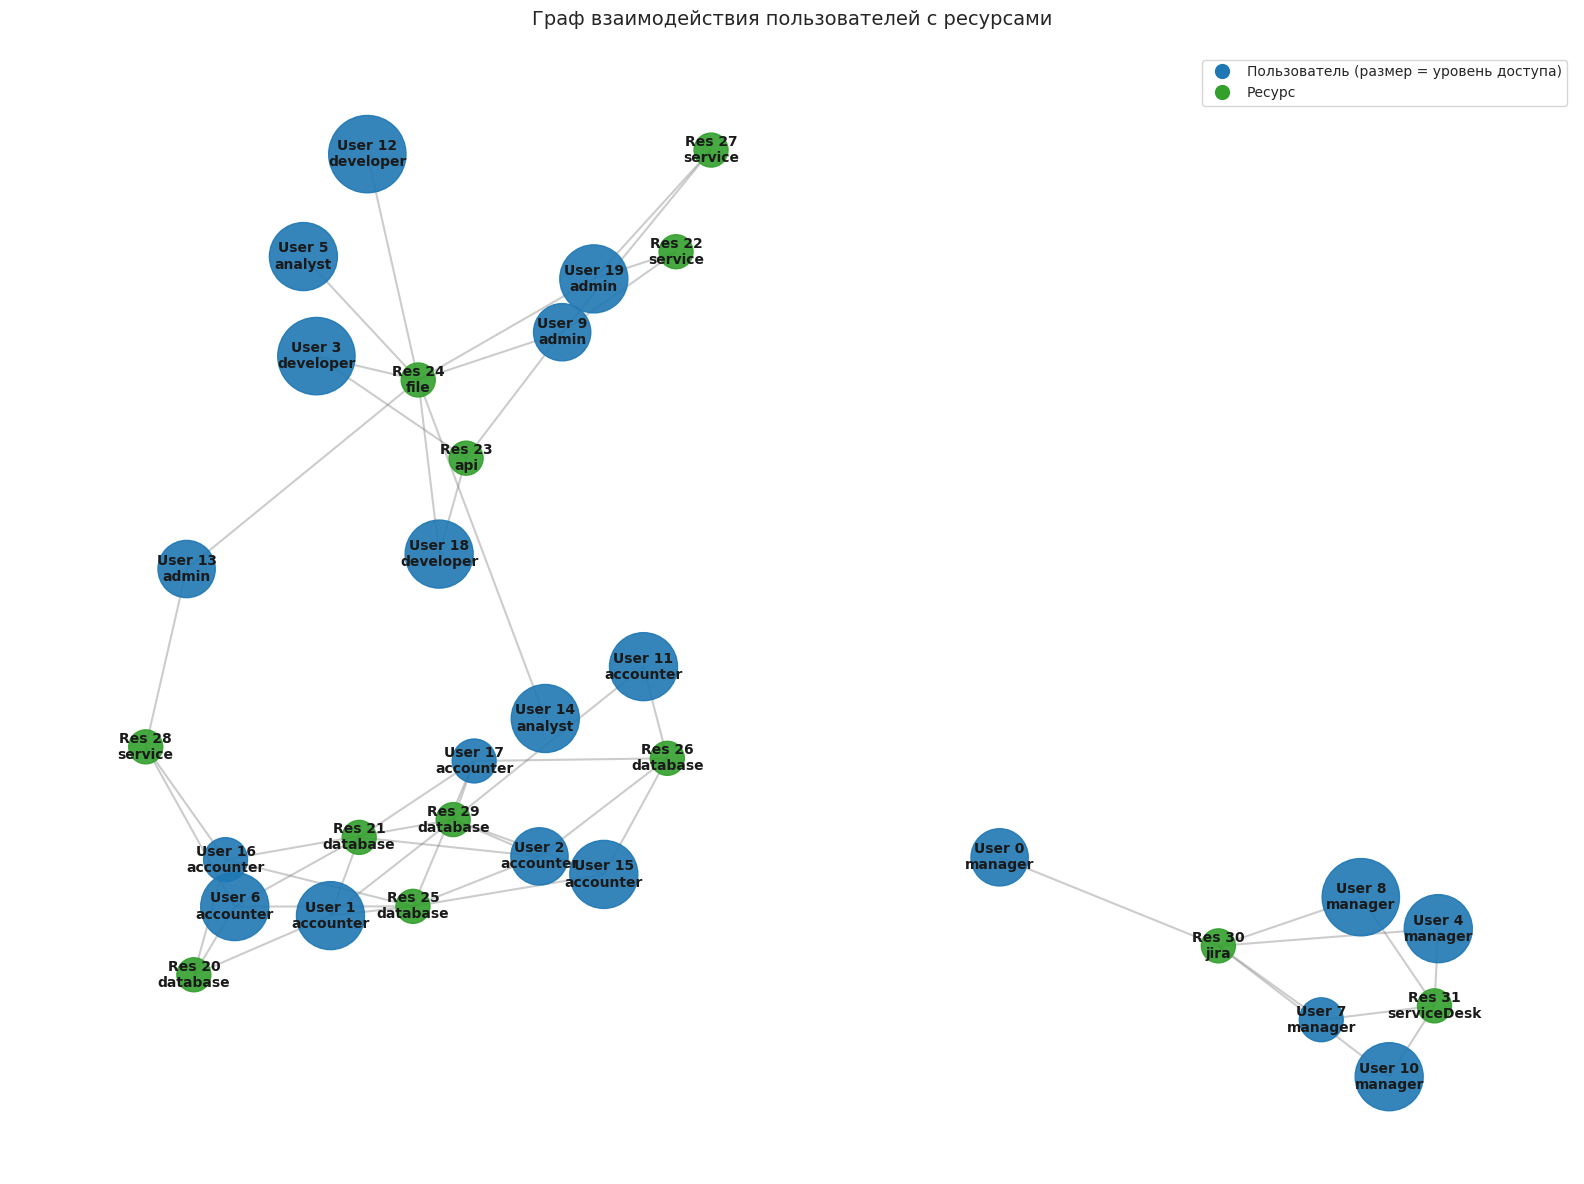

In [93]:
# Ещё большее масштабирование узлов по уровню доступа
def visualize_interaction_graph_scaled_strongest(nodes_df, resources_df, edges_df):
    import matplotlib.pyplot as plt
    import networkx as nx

    G = nx.Graph()
    offset = len(nodes_df)

    # Узлы пользователей — с ещё большей разницей по размеру
    for user_id, row in nodes_df.iterrows():
        access_level = row['access_level']
        role = row['role']
        G.add_node(user_id,
                   role=role,
                   access_level=access_level,
                   node_type='user',
                   color='#1f78b4',
                   size=300 + 700 * access_level)  # Максимально выраженное масштабирование

    # Узлы ресурсов
    for res_id, row in resources_df.iterrows():
        global_res_id = offset + res_id
        G.add_node(global_res_id,
                   resource_type=row['resource_type'],
                   node_type='resource',
                   color='#33a02c',
                   size=600)

    # Рёбра
    for _, row in edges_df.iterrows():
        source = row['source_user']
        target = offset + row['target_resource']
        G.add_edge(source, target, weight=row['weight'])

    # Визуализация
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)

    node_colors = [data['color'] for _, data in G.nodes(data=True)]
    node_sizes = [data['size'] for _, data in G.nodes(data=True)]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.4, edge_color='gray')

    labels = {
        node: f"User {node}\n{data['role']}" if data['node_type'] == 'user'
        else f"Res {node}\n{data['resource_type']}"
        for node, data in G.nodes(data=True)
    }
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Пользователь (размер = уровень доступа)',
                   markerfacecolor='#1f78b4', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='Ресурс',
                   markerfacecolor='#33a02c', markersize=12)
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop={'size': 10})
    plt.title("Граф взаимодействия пользователей с ресурсами", fontsize=14, pad=20)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Визуализация с максимальным масштабом узлов
visualize_interaction_graph_scaled_strongest(nodes_df, resources_df, edges_df)

/tmp/ipykernel_79522/63255623.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  user_cmap = cm.get_cmap("Blues")
/tmp/ipykernel_79522/63255623.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  res_cmap = cm.get_cmap("Greens")


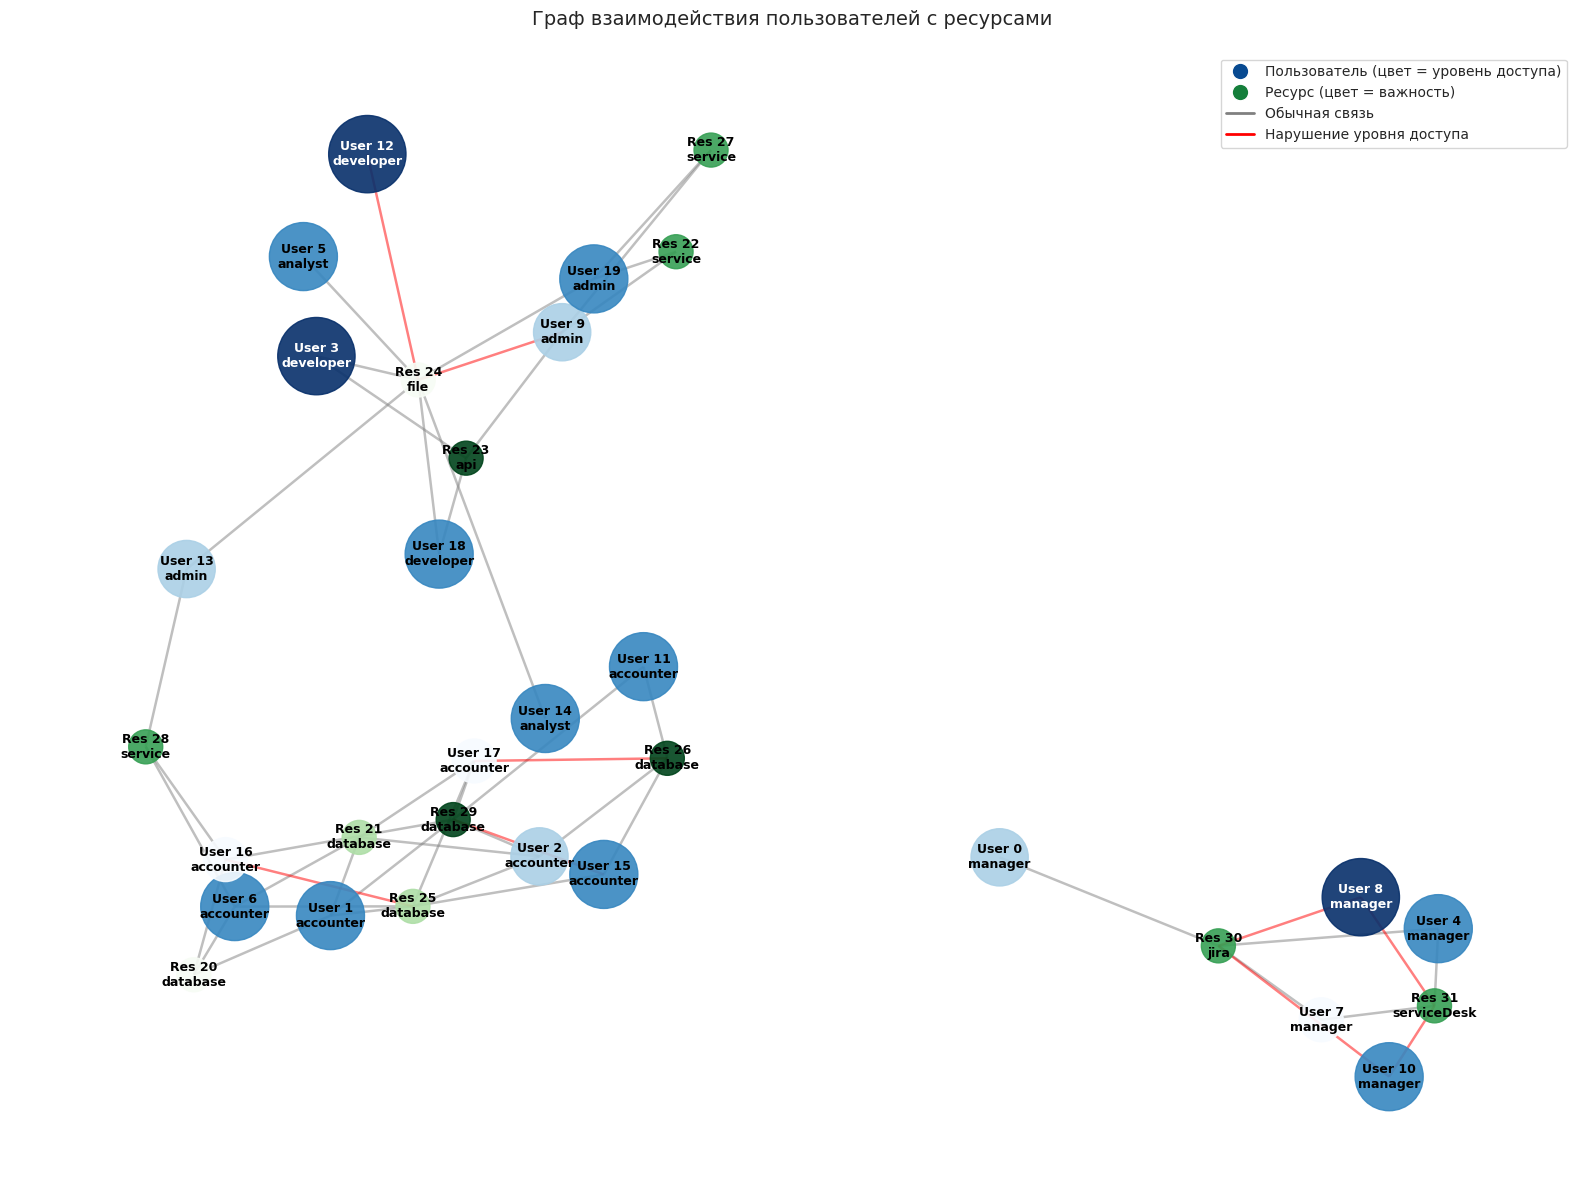

In [94]:
# Повтор визуализации с адаптацией цвета текста на тёмных узлах пользователей
def visualize_graph_with_violation_and_label_contrast(nodes_df, resources_df, edges_df):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    import networkx as nx

    G = nx.Graph()
    offset = len(nodes_df)

    # Цветовые шкалы
    user_norm = mcolors.Normalize(vmin=1, vmax=nodes_df["access_level"].max())
    user_cmap = cm.get_cmap("Blues")
    res_norm = mcolors.Normalize(vmin=1, vmax=resources_df["importance"].max())
    res_cmap = cm.get_cmap("Greens")

    # Узлы пользователей
    for user_id, row in nodes_df.iterrows():
        access_level = row['access_level']
        role = row['role']
        color_rgb = user_cmap(user_norm(access_level))
        color_hex = mcolors.to_hex(color_rgb)
        G.add_node(user_id,
                   role=role,
                   access_level=access_level,
                   node_type='user',
                   color=color_hex,
                   rgb=color_rgb,
                   size=300 + 700 * access_level)

    # Узлы ресурсов
    for res_id, row in resources_df.iterrows():
        global_res_id = offset + res_id
        color = mcolors.to_hex(res_cmap(res_norm(row["importance"])))
        G.add_node(global_res_id,
                   resource_type=row["resource_type"],
                   access_level=row["access_level"],
                   node_type='resource',
                   color=color,
                   rgb=(1, 1, 1),  # белый текст
                   size=600)

    # Рёбра и их цвета
    edge_colors = []
    for _, row in edges_df.iterrows():
        source = row['source_user']
        target = offset + row['target_resource']
        user_level = nodes_df.loc[source, "access_level"]
        resource_level = resources_df.loc[row['target_resource'], "access_level"]
        violation = user_level < resource_level

        G.add_edge(source, target, weight=row['weight'], violation=violation)
        edge_colors.append('red' if violation else 'gray')

    # Визуализация
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)

    node_colors = [data['color'] for _, data in G.nodes(data=True)]
    node_sizes = [data['size'] for _, data in G.nodes(data=True)]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=1.8, alpha=0.5, edge_color=edge_colors)

    # Подписи с адаптацией цвета текста
    for node, data in G.nodes(data=True):
        label = f"User {node}\n{data['role']}" if data['node_type'] == 'user' else f"Res {node}\n{data['resource_type']}"
        text_color = 'white' if sum(data['rgb'][:3]) < 1.2 else 'black'  # если цвет очень тёмный, делаем белым
        x, y = pos[node]
        plt.text(x, y, label, fontsize=9, fontweight='bold', ha='center', va='center', color=text_color)

    # Легенда
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Пользователь (цвет = уровень доступа)',
                   markerfacecolor=user_cmap(0.9), markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='Ресурс (цвет = важность)',
                   markerfacecolor=res_cmap(0.8), markersize=12),
        plt.Line2D([0], [0], color='gray', lw=2, label='Обычная связь'),
        plt.Line2D([0], [0], color='red', lw=2, label='Нарушение уровня доступа')
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop={'size': 10})
    plt.title("Граф взаимодействия пользователей с ресурсами", fontsize=14, pad=20)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Вызов визуализации с адаптивной контрастностью текста
visualize_graph_with_violation_and_label_contrast(nodes_df, resources_df, edges_df)


### LSTM (Long Short-Term Memory):
* Для анализа последовательности действий пользователей на ресурсах используется LSTM. Это рекуррентная нейронная сеть, которая может работать с последовательностями данных, запоминая важные моменты из предыдущих состояний.
* Данные о действиях пользователей (содержащие информацию о времени суток, типе события и других признаках) преобразуются в последовательности и подаются в LSTM.

In [95]:
# === LSTM часть: последовательности действий ===
edges_df = edges_df.dropna(subset=['event_type'])
edges_df['event_type_id'] = LabelEncoder().fit_transform(edges_df['event_type'])
edges_df['hour'] = edges_df['timestamp'].dt.hour
edges_df['dayofweek'] = edges_df['timestamp'].dt.dayofweek

features = ['hour', 'dayofweek', 'event_type_id', 'weight']
sequences = []
user_ids = sorted(edges_df['source_user'].unique())

for user_id in user_ids:
    user_seq = edges_df[edges_df['source_user'] == user_id].sort_values('timestamp')[features].values
    sequences.append(user_seq)

max_len = max(len(seq) for seq in sequences)
num_features = len(features)
padded = np.zeros((len(sequences), max_len, num_features))
for i, seq in enumerate(sequences):
    padded[i, :len(seq), :] = seq

lstm_input_tensor = torch.tensor(padded, dtype=torch.float)

### Выполним разделение индексов пользователей на обучающую и тестовую выборки с использованием функции train_test_split из библиотеки scikit-learn

In [96]:
# === Маски и данные ===
num_users = y.shape[0] #user_features.shape[0]

In [97]:
train_idx, test_idx = train_test_split(np.arange(num_users), test_size=0.3, stratify=y, random_state=42)

np.arange(num_users) - cоздаётся массив индексов от 0 до num_users - 1, где num_users — общее количество пользователей в данных. Это нужно, чтобы разделить самих пользователей, а не их признаки.

test_size=0.3 - задаётся размер тестовой выборки — 30% от общего числа пользователей. Остальные 70% войдут в обучающую выборку.

stratify=y - обеспечивает стратифицированное разделение, то есть пропорции классов (меток y) в обучающей и тестовой выборках будут соответствовать их пропорциям в исходных данных.

random_state=42 - фиксирует случайное состояние для воспроизводимости результатов. При одинаковом random_state разделение будет одинаковым при каждом запуске кода

Результат:
* train_idx — индексы пользователей, попавших в обучающую выборку.
* test_idx — индексы пользователей, попавших в тестовую выборку.

In [98]:
train_mask = torch.zeros(num_users, dtype=torch.bool)
test_mask = torch.zeros(num_users, dtype=torch.bool)

In [99]:
train_mask[train_idx] = True
test_mask[test_idx] = True

In [100]:
train_idx

array([ 3,  4,  1, 19, 18,  8,  6,  0,  2, 15, 13, 16, 10, 14])

In [101]:
test_idx

array([ 9,  7, 11, 12, 17,  5])

### Модель GCN + LSTM.
Модель состоит из двух частей:
* GCN: Извлекает скрытые представления для пользователей на основе их взаимодействий с ресурсами.
* LSTM: Анализирует последовательность действий пользователей, чтобы предсказать их поведение в будущем.
* Модель комбинирует скрытые представления из GCN и LSTM, используя полносвязный слой (fc), чтобы предсказать роль пользователя (классификация).

In [102]:
import torch.nn.functional as F
# === Гибридная модель ===
class GCN_LSTM_Hybrid(nn.Module):
    def __init__(self, gcn_in, gcn_hidden, lstm_in, lstm_hidden, out_dim):
        super().__init__()
        self.gcn = GCNConv(gcn_in, gcn_hidden)
        self.lstm = nn.LSTM(input_size=lstm_in, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(gcn_hidden + lstm_hidden, out_dim)

    def forward(self, data, sequences):
        x_gcn = F.relu(self.gcn(data.x, data.edge_index))

        x_users = x_gcn[:sequences.size(0)]
        lstm_out, _ = self.lstm(sequences)
        lstm_last = lstm_out[:, -1, :]
        x_combined = torch.cat([x_users, lstm_last], dim=1)
        return self.fc(x_combined)

model = GCN_LSTM_Hybrid(
    gcn_in=6, gcn_hidden=16,
    lstm_in=4, lstm_hidden=16,
    out_dim=len(torch.unique(y))
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

### Обучение и тестирование:
* В цикле обучения производится обновление параметров модели с использованием градиентного спуска.
* Вычисляется кросс-энтропийная ошибка для оценки производительности модели.
* Модель оценивается по точности на тестовой выборке.

In [103]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data, lstm_input_tensor)
    loss = criterion(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data, lstm_input_tensor)
        pred = out.argmax(dim=1)
        correct = (pred[test_mask] == y[test_mask]).sum().item()
        return correct / test_mask.sum().item()

losses = []
accuracies = []

for epoch in range(1, 101):
    loss = train()
    acc = test()
    losses.append(loss)
    accuracies.append(acc)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}")


Epoch 010, Loss: 44.1821, Test Acc: 0.1667
Epoch 020, Loss: 16.5373, Test Acc: 0.3333
Epoch 030, Loss: 8.0352, Test Acc: 0.3333
Epoch 040, Loss: 8.3963, Test Acc: 0.1667
Epoch 050, Loss: 11.9215, Test Acc: 0.0000
Epoch 060, Loss: 1.8015, Test Acc: 0.1667
Epoch 070, Loss: 1.8908, Test Acc: 0.1667
Epoch 080, Loss: 0.6226, Test Acc: 0.1667
Epoch 090, Loss: 0.2208, Test Acc: 0.1667
Epoch 100, Loss: 0.1170, Test Acc: 0.1667


### Визуализация результатов:
* После обучения модели, проводится визуализация данных на графе, где каждый узел представляет пользователя или ресурс.
* Узлы визуализируются с разными размерами и цветами в зависимости от их предсказаний (анализ аномалий).
* Используется библиотека networkx для построения графа, где рёбра представляют взаимодействия между пользователями и ресурсами.

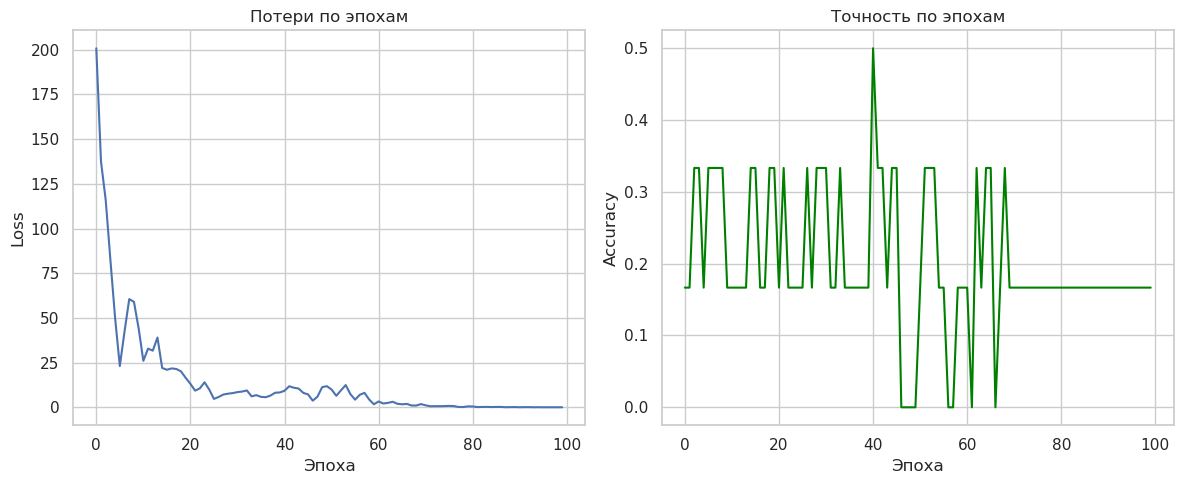

In [104]:
#Визуализация обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title("Потери по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.title("Точность по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 001 | Loss: 0.0771 | Accuracy: 1.0000
Epoch 010 | Loss: 0.0642 | Accuracy: 1.0000
Epoch 020 | Loss: 0.0522 | Accuracy: 1.0000
Epoch 030 | Loss: 0.0455 | Accuracy: 1.0000
Epoch 040 | Loss: 0.0411 | Accuracy: 1.0000
Epoch 050 | Loss: 0.0377 | Accuracy: 1.0000
Epoch 060 | Loss: 0.0348 | Accuracy: 1.0000
Epoch 070 | Loss: 0.0321 | Accuracy: 1.0000
Epoch 080 | Loss: 0.0295 | Accuracy: 1.0000
Epoch 090 | Loss: 0.0272 | Accuracy: 1.0000
Epoch 100 | Loss: 0.0250 | Accuracy: 1.0000


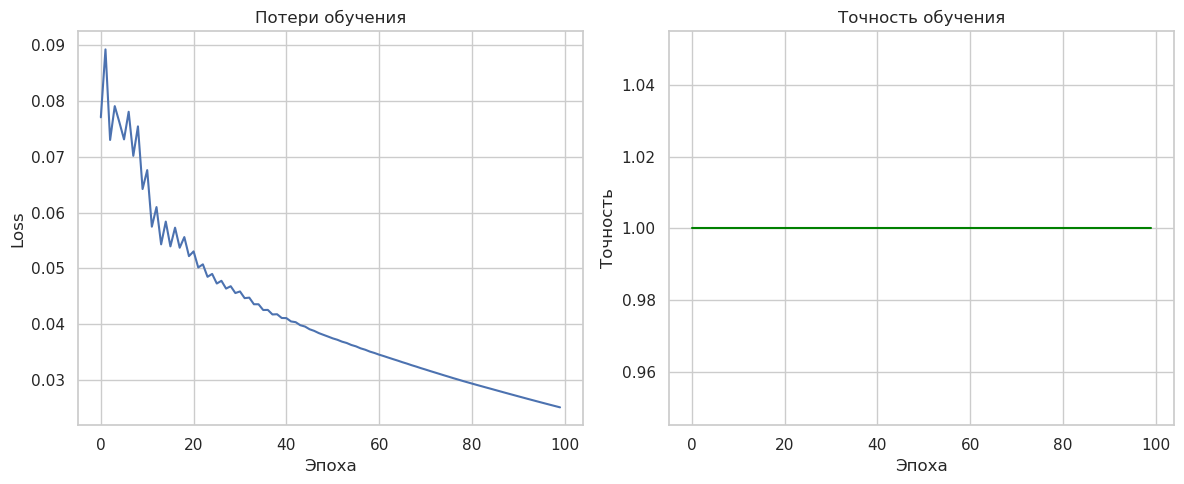

In [105]:
# === Инициализация логов ===
train_losses = []
train_accuracies = []

num_epochs = 100  # классический выбор
# === Обучение модели ===
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    out = model(data, lstm_input_tensor)
    loss = criterion(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()

    # === Логирование ===
    train_losses.append(loss.item())
    pred = out.argmax(dim=1)
    correct = (pred[train_mask] == y[train_mask]).sum().item()
    acc = correct / train_mask.sum().item()
    train_accuracies.append(acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")

# === Визуализация ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Потери обучения")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='green')
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность обучения")
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 001 | Loss: 0.0248 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 010 | Loss: 0.0229 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 020 | Loss: 0.0208 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 030 | Loss: 0.0188 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 040 | Loss: 0.0170 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 050 | Loss: 0.0154 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 060 | Loss: 0.0140 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 070 | Loss: 0.0128 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 080 | Loss: 0.0118 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 090 | Loss: 0.0109 | Train Acc: 1.0000 | Test Acc: 0.1667
Epoch 100 | Loss: 0.0101 | Train Acc: 1.0000 | Test Acc: 0.1667


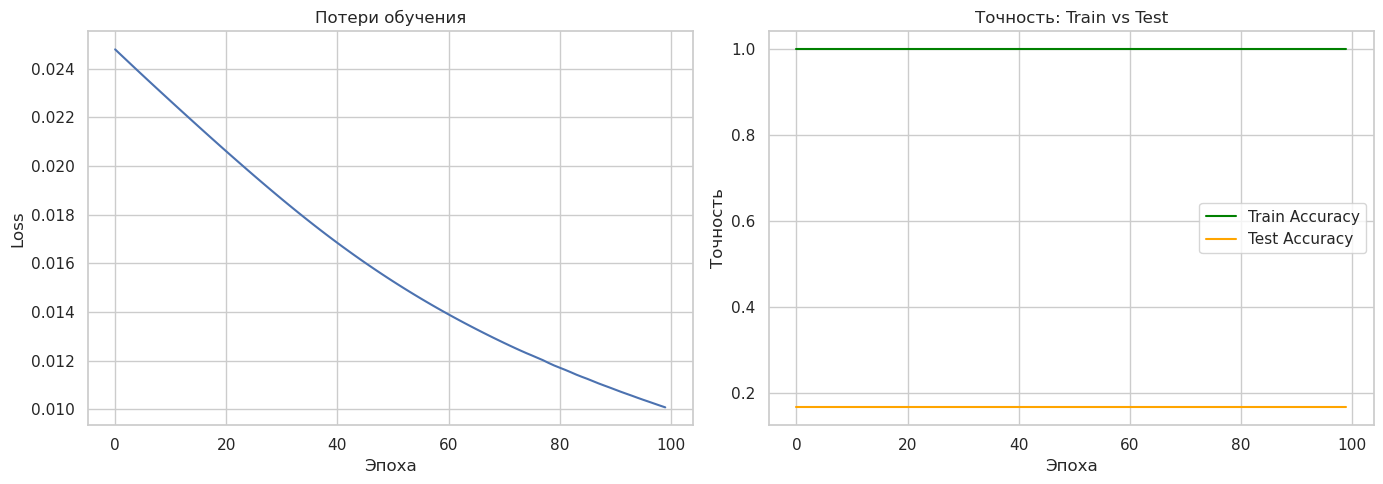

In [106]:
# === Инициализация логов ===
train_losses = []
train_accuracies = []
test_accuracies = []

# === Обучение модели ===
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    out = model(data, lstm_input_tensor)
    loss = criterion(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()

    # === Логирование ===
    train_losses.append(loss.item())

    pred = out.argmax(dim=1)

    # Точность на train
    correct_train = (pred[train_mask] == y[train_mask]).sum().item()
    acc_train = correct_train / train_mask.sum().item()
    train_accuracies.append(acc_train)

    # Точность на test
    correct_test = (pred[test_mask] == y[test_mask]).sum().item()
    acc_test = correct_test / test_mask.sum().item()
    test_accuracies.append(acc_test)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f}")

# === Визуализация ===
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Потери обучения")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='green')
plt.plot(test_accuracies, label="Test Accuracy", color='orange')
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность: Train vs Test")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### t-SNE визуализация скрытых представлений после GCN слоя

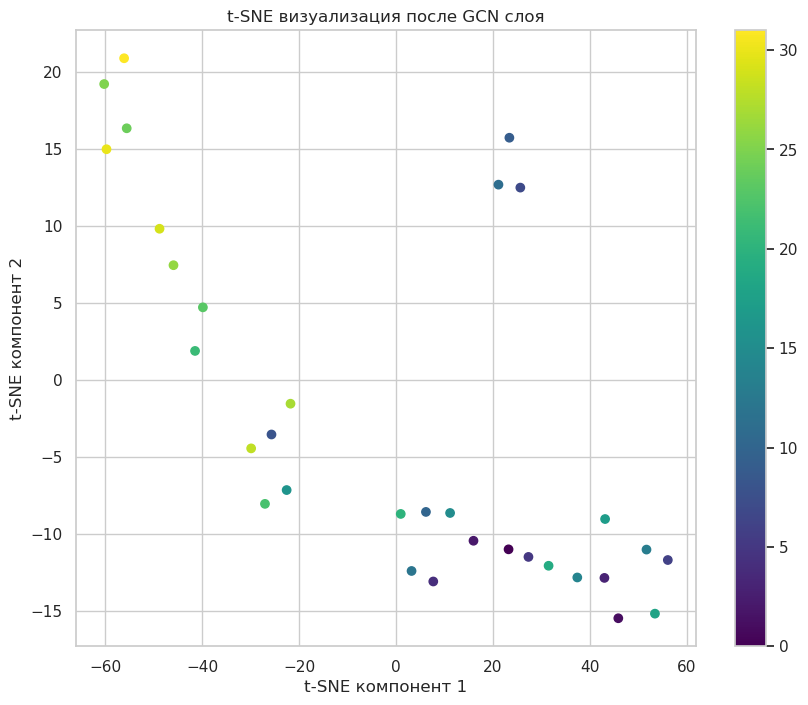

In [107]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Применим модель в режиме оценки
model.eval()

# Извлекаем скрытые представления после первого слоя GCN
with torch.no_grad():
    x_hidden = model.gcn(data.x, data.edge_index)  # Используем правильный атрибут
    x_hidden = F.relu(x_hidden)  # Применяем активацию ReLU

# Применим t-SNE к скрытым представлениям
x_hidden_np = x_hidden.cpu().numpy()  # Переводим тензор в numpy для работы с t-SNE

# Если количество данных меньше 30, уменьшаем perplexity
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # Устанавливаем perplexity = 5
x_tsne = tsne.fit_transform(x_hidden_np)  # Применяем t-SNE

# Если data.y существует, используем его для раскраски точек
if data.y is not None:
    color_data = data.y.cpu().numpy()
else:
    color_data = range(len(x_tsne))  # Если нет меток, используем индексы узлов

# Визуализируем результат
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=color_data, cmap='viridis')
plt.colorbar()
plt.title("t-SNE визуализация после GCN слоя")
plt.xlabel("t-SNE компонент 1")
plt.ylabel("t-SNE компонент 2")
plt.show()


### Отображение предсказаний модели на графе

Функция visualize_graph строит граф с пользователями и ресурсами, отображая на нём предсказания модели (аналогичные нормальным и аномальным действиям). Визуализация включает в себя размеры узлов (основанные на уровне доступа) и раскраску узлов (зеленый для нормальных действий, красный — для аномальных). Графики отображаются с помощью matplotlib.

Прогнозы: tensor([4, 0, 0, 3, 4, 4, 0, 0, 4, 0, 4, 1, 4, 1, 2, 0, 0, 0, 3, 1])


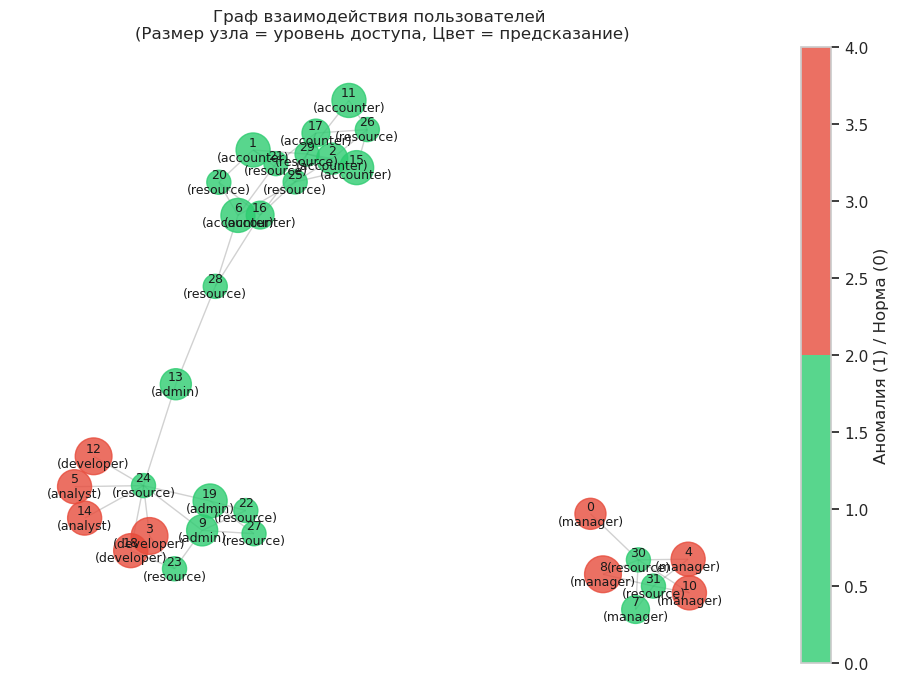

In [108]:
import networkx as nx
from matplotlib.colors import ListedColormap

# Проверка предсказаний
model.eval()
with torch.no_grad():
    out = model(data, lstm_input_tensor)
    predictions = out.argmax(dim=1)
    print("Прогнозы:", predictions)

def visualize_graph(data, predictions, node_roles):
    G = nx.Graph()

    # Add nodes with attributes
    num_users = len(node_roles)  # Only users have roles
    for i in range(num_users):
        G.add_node(i,
                  role=node_roles[i],
                  pred=int(predictions[i]),
                  conf=float(torch.exp(out[i]).max()))

    # For resource nodes (no predictions)
    for i in range(num_users, len(data.x)):
        G.add_node(i,
                  role='resource',
                  pred=-1,  # No prediction for resources
                  conf=0.0)

    # Add edges with weights
    for src, dst in data.edge_index.t().numpy():
        G.add_edge(src, dst)

    # Node colors
    cmap = ListedColormap(['#2ecc71', '#e74c3c'])  # Green=normal, Red=anomaly
    node_colors = [G.nodes[n]['pred'] if G.nodes[n]['pred'] != -1 else 0 for n in G.nodes]

    # Node sizes based on access level
    node_sizes = [300 + 100*data.x[i][2].item() if i < num_users else 300 for i in G.nodes]

    # Node positions
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=1)

    # Draw nodes
    nodes_draw = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=cmap,
        node_size=node_sizes,
        alpha=0.8
    )

    # Node labels
    labels = {n: f"{n}\n({G.nodes[n]['role']})" for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=9)

    # Legend
    plt.colorbar(nodes_draw, label="Аномалия (1) / Норма (0)")
    plt.title("Граф взаимодействия пользователей \n(Размер узла = уровень доступа, Цвет = предсказание)")
    plt.axis('off')
    plt.show()

# Список ролей пользователей
node_roles = nodes_df['role'].tolist()

# Вызов функции визуализации
visualize_graph(data, predictions, node_roles)
